In [77]:
import os
import numpy as np
import scipy as sp
from tqdm import tqdm
from time import time

from src.utils import *

In [174]:
dataset = "10"
filename = os.path.join(os.getcwd(), f"data/{dataset}.npz")

In [175]:
ts, features, linear_velocity, angular_velocity, K, b, imu_T_cam = load_data(filename)

In [176]:
IMU_flip = np.zeros((3,3))
IMU_flip[0,0] = 1
IMU_flip[1,1] = -1
IMU_flip[2,2] = -1

imu_T_cam[:3,:3] = IMU_flip @ imu_T_cam[:3,:3]
imu_T_cam

array([[ 0.03717833, -0.09861822,  0.9944306 ,  1.5752681 ],
       [-0.99926755,  0.00535534,  0.03789026,  0.00439141],
       [-0.00906218, -0.99511094, -0.09834688, -0.65      ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [177]:
Ks = np.vstack((K, np.zeros(3)))
Ks = np.hstack((Ks, np.zeros((4,1))))
Ks[3,:] = Ks[1,:]
Ks[2,:] = Ks[0,:]
Ks[2,3] = -Ks[0, 0] * b

P = np.hstack((np.eye(3,3), np.zeros((3,1))))
Ks, P

(array([[ 552.554261 ,    0.       ,  682.049453 ,    0.       ],
        [   0.       ,  552.554261 ,  238.769549 ,    0.       ],
        [ 552.554261 ,    0.       ,  682.049453 , -331.5325566],
        [   0.       ,  552.554261 ,  238.769549 ,    0.       ]]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]]))

In [178]:
def get_world_coordinates(K, b, imu_T_cam, T, pixel_coordinates):
    Fsu = K[0,0]
    Fsv = K[1,1]
    Cu = K[0,2]
    Cv = K[1,2]

    uL = pixel_coordinates[0,:]
    vL = pixel_coordinates[1,:]
    uR = pixel_coordinates[2,:]
    vR = pixel_coordinates[3,:]

    z = Fsu * b / (uL - uR)
    x = z * (uL - Cu) / Fsu
    y = z * (vL - Cv) / Fsv
    ones = np.ones_like(z)

    camera_h_coordinates = np.stack((x,y,z,ones))
    imu_h_coodinates = imu_T_cam @ camera_h_coordinates
    world_h_coordinates = T @ imu_h_coodinates

    return world_h_coordinates


In [179]:
tau = np.zeros_like(ts)
tau[0, 1:] = ts[0, 1:] - ts[0, :-1]
tau = np.squeeze(tau)

gen_velocity = np.vstack((linear_velocity, angular_velocity))

In [180]:
def get_dot_circ(s):
    s_dot_circ = np.empty(s.shape[:-1]+(4,6))
    s_dot_circ[...,:3,:3] = np.eye(3,3)
    s_dot_circ[...,:3,3:] = -axangle2skew(s[:,:3])
    s_dot_circ[..., 3, :] = np.zeros(6)

    return s_dot_circ

In [181]:
def remove_landmark_outliers(landmarks):
    v = np.logical_and(np.logical_and(landmarks[0,:] > -1500, landmarks[0,:] < 300), np.logical_and(landmarks[1,:] > -1500, landmarks[1,:] < 1000))
    clipped_landmarks = landmarks[:,v]
    return clipped_landmarks

In [ ]:
step = 20
num_landmarks = features[:,::step,:].shape[1]
m3 = 3 * num_landmarks

landmark_mu = np.zeros((3, num_landmarks))

# combined_cov_t = np.eye(m3 + 6, m3 + 6) * 1e-3
# combined_cov_t[-6:,-6:] = np.diag([1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5])

# motion_noise_cov = np.diag([1e-6, 1e-6, 1e-6, 1e-8, 1e-8, 1e-8])
# observation_noise_cov = np.eye(4,4) * 10

combined_cov_t = np.eye(m3 + 6, m3 + 6) * 1e-1
combined_cov_t[-6:,-6:] = np.diag([1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5])

motion_noise_cov = np.diag([1e-7, 1e-7, 1e-7, 1e-9, 1e-9, 1e-9])
observation_noise_cov = np.eye(4,4) * 6

slam_robot_poses = [np.eye(4,4)]
# robot_pose_delta_t = np.random.multivariate_normal(mean = np.zeros((6,)), cov = combined_cov_t[-6:,-6:])

for t_idx in tqdm(range(ts.shape[1]-1)):
    pose_t = slam_robot_poses[-1]

    # Prediction step
    # noise = np.random.multivariate_normal(mean=np.zeros((6,)), cov=motion_noise_cov)
    velocity = gen_velocity[:,t_idx]
    
    pose_t = pose_t @ twist2pose(tau[t_idx+1] * axangle2twist(velocity))
    # robot_pose_delta_t_1 = exp_mean_perturb[t_idx,:,:] @ robot_pose_delta_t + noise

    F = sp.linalg.expm(-tau[t_idx+1] * axangle2adtwist(velocity))

    # Prediction of covariance
    combined_cov_t[-6:,-6:] = F @ combined_cov_t[-6:,-6:] @ F.T + motion_noise_cov
    combined_cov_t[:m3,-6:] = combined_cov_t[:m3,-6:] @ F.T
    combined_cov_t[-6:,:m3] = F @ combined_cov_t[-6:,:m3]

    # Observation Prediction
    all_obs = features[:, ::step, t_idx]

    # Pick only visible
    cols = np.where(all_obs != np.array([[-1,-1,-1,-1]]).T)[1]
    visible = cols[:cols.shape[0]//4]

    visible_obs = all_obs[:, visible]
    world_h_coordinates = get_world_coordinates(K, b, imu_T_cam, pose_t, visible_obs)
    
    uninit_landmark = landmark_mu == np.zeros((3,1))
    uninit_landmark = np.where(np.sum(uninit_landmark, axis=0) == 3)[0]
    mean_init_idx = set(visible).intersection(set(uninit_landmark))

    for idx, feature_num in enumerate(sorted(mean_init_idx)):
        landmark_mu[:, feature_num] = world_h_coordinates[:3, idx]
    
    mean_update_idx = set(visible) - mean_init_idx

    # Filter the points far away from robot
    valid = []
    for idx in mean_update_idx:
        diff = landmark_mu[:,idx] -  pose_t[:3,3]
        if np.all(np.abs(diff) < 200):
            valid.append(idx)

    valid = np.array(valid)
    Nt = valid.shape[0]

    if Nt == 0:
        slam_robot_poses.append(pose_t)
        continue

    update_obs = all_obs[:, valid]
    
    landmark_mu_flattened = landmark_mu.T.reshape(-1)

    landmark_mu_h_coords_t = landmark_mu[:, valid]
    landmark_mu_h_coords_t = np.vstack((landmark_mu_h_coords_t, np.ones(landmark_mu_h_coords_t.shape[1])))
    camera_h_coords = np.linalg.inv(pose_t) @ landmark_mu_h_coords_t
    optical_h_coords = np.linalg.inv(imu_T_cam) @ camera_h_coords
    normalized_optical_coords = optical_h_coords / optical_h_coords[2,:]

    predicted_obs = Ks @ normalized_optical_coords

    innovation = update_obs - predicted_obs

    # Jacobian calculation
    jacobian = projectionJacobian(predicted_obs.T)  # Nt * 4 * 4
    pose_H_t = -Ks @ jacobian @ np.linalg.inv(imu_T_cam) @ get_dot_circ(camera_h_coords.T) # Nt * 4 * 6
    landmark_H_t = Ks @ jacobian @ np.linalg.inv(imu_T_cam) @ np.linalg.inv(pose_t) @ P.T # Nt * 4 * 3

    H = np.zeros((4*Nt, m3 + 6))
    observation_noise_cov_stacked = np.zeros((4*Nt, 4*Nt))
    for i in range(Nt):
        H[4*i:4*i+4,3*valid[i]:3*valid[i]+3] = landmark_H_t[i,:,:]
        H[4*i:4*i+4,-6:] = pose_H_t[i,:,:]
        observation_noise_cov_stacked[4*i:4*i+4, 4*i:4*i+4] = observation_noise_cov
    
    # Kalman_gain = combined_cov_t @ H.T @ np.linalg.inv(H @ combined_cov_t @ H.T + observation_noise_cov_stacked)

    Kalman_gain = np.linalg.solve(H @ combined_cov_t @ H.T + observation_noise_cov_stacked, H @ combined_cov_t)
    Kalman_gain = Kalman_gain.T
    
    # Update step
    updates = np.squeeze(Kalman_gain @ innovation.T.reshape((-1,1)))

    landmark_mu_flattened = landmark_mu_flattened + updates[:m3]
    landmark_mu = landmark_mu_flattened.reshape((-1,3)).T

    pose_t = pose_t @ axangle2pose(updates[m3:])
    combined_cov_t = (np.eye(m3+6, m3+6) - Kalman_gain @ H) @ combined_cov_t

    slam_robot_poses.append(pose_t)

slam_robot_poses = np.stack(slam_robot_poses)
slam_robot_poses = slam_robot_poses.transpose((1,2,0))

In [185]:
num_landmarks

665

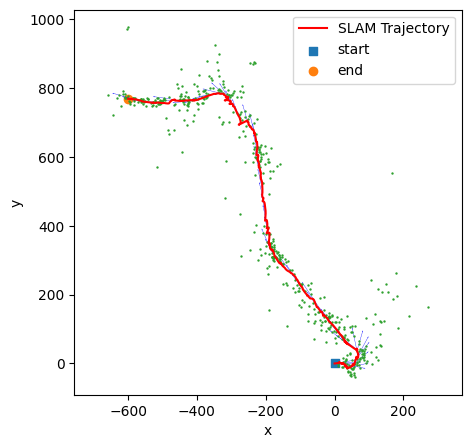

In [169]:
clipped_landmarks = remove_landmark_outliers(landmark_mu)
fig, ax = visualize_trajectory_2d(slam_robot_poses, clipped_landmarks, path_name="SLAM Trajectory", show_ori=True)

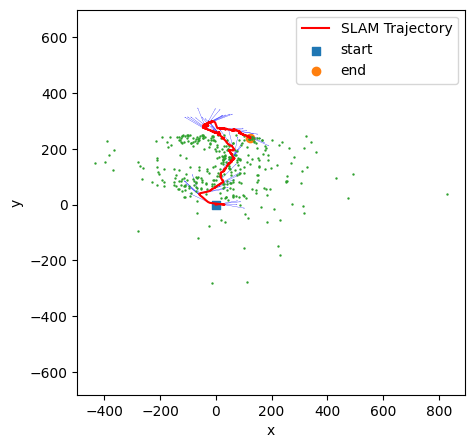

In [155]:
clipped_landmarks = remove_landmark_outliers(landmark_mu)
fig, ax = visualize_trajectory_2d(slam_robot_poses, clipped_landmarks, path_name="SLAM Trajectory", show_ori=True)

In [170]:
fig.savefig(f"results/slam-map-{dataset}-{step}.png", dpi=600)
np.save(f"results/slam_robot_poses-{dataset}-{step}.npy", slam_robot_poses)
np.save(f"results/clipped-landmarks-{dataset}-{step}.npy", clipped_landmarks)
np.save(f"results/unclipped-landmarks-{dataset}-{step}.npy", landmark_mu)

In [19]:
step = 10

In [20]:
slam_robot_poses = np.load(f"results/slam_robot_poses-{dataset}-{step}.npy")
landmark_mu = np.load(f"results/unclipped-landmarks-{dataset}-{step}.npy")


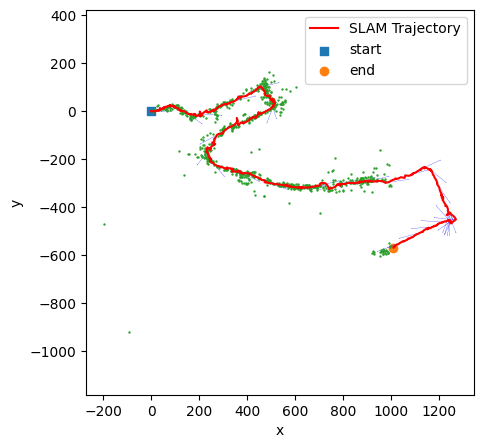

In [21]:
clipped_landmarks = remove_landmark_outliers(landmark_mu)
fig, ax = visualize_trajectory_2d(slam_robot_poses, clipped_landmarks, path_name="SLAM Trajectory", show_ori=True)

In [22]:
fig.savefig(f"results/slam-map-{dataset}-{step}.png", dpi=600)